## object-detection ref : https://towardsdatascience.com/object-detection-with-less-than-10-lines-of-code-using-python-2d28eebc5b11

## color-extraction ref : https://code.likeagirl.io/finding-dominant-colour-on-an-image-b4e075f98097

In [1]:
import cv2
import matplotlib.pyplot as plt
import cvlib as cv
from cvlib.object_detection import draw_bbox

import numpy as np
from sklearn.cluster import KMeans
from collections import Counter
import json

Using TensorFlow backend.


## 1. Load image file

>>> type of img     : <class 'numpy.ndarray'>
>>> size of matrix : (1349, 1080, 3)


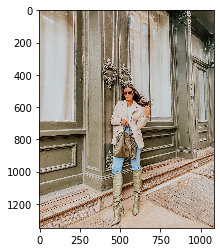

In [2]:
file_path = '../data/pictures_thecatwilliams/thecatwilliams_004_502Likes.png'
img = cv2.imread(file_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print(f'>>> type of img     : {type(img)}')
print(f'>>> size of matrix : {img.shape}')
plt.imshow(img)
plt.show()

## 2. Detect the object 'person' from image

=== outputs ===
bounding boxes    : [[412, 449, 674, 1295]]
detected objects  : ['person']
confidence levels : [0.9972981810569763]



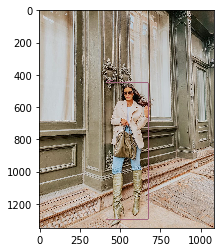

In [3]:
bbox, label, conf = cv.detect_common_objects(img)
print('=== outputs ===')
print(f'bounding boxes    : {bbox}')  # left_upper_x, left_upper_y, left_upper_x + width, left_upper_y + height
print(f'detected objects  : {label}')
print(f'confidence levels : {conf}\n')

if label.count('person') > 1:   # Exceptional case : 2 or more persons are detected
    print('>>> Warning : More than 1 person is detected from the given picture!')
    idx = label.index('person')
    bbox = [bbox[idx]]
    label = [label[idx]]
    conf = [conf[idx]]
    
    output_image = draw_bbox(img, bbox, label, conf)
    plt.imshow(output_image)
    plt.show()
elif 'person' in label:   # Ideal case : only one main preson is detected
    idx = label.index('person')
    bbox = [bbox[idx]]
    label = [label[idx]]
    conf = [conf[idx]]
    
    output_image = draw_bbox(img, bbox, label, conf)
    plt.imshow(output_image)
    plt.show()
else:   # Exceptional case : No person is detected
    print('>>> Warning : No person is detected from the given picture!')
    output_image = draw_bbox(img, bbox, label, conf)
    plt.imshow(output_image)
    plt.show()

## 3. Extract dominant colors of Un-detected area (background)

#### 3-1. Preprocess image

In [4]:
x, y, w, h = bbox[0]

top = img[ :y , : ]
bottom = img[ h: , : ]
left = img[ y:h , :x ]
right = img[ y:h , w: ]

# represent as row*column,channel number (appropriate format for KMeans)
top_reshape    = top.reshape(top.shape[0]*top.shape[1], 3)
bottom_reshape = bottom.reshape(bottom.shape[0]*bottom.shape[1], 3)
left_reshape   = left.reshape(left.shape[0]*left.shape[1], 3)
right_reshape  = right.reshape(right.shape[0]*right.shape[1], 3)

# array concatenation
concat_arr = np.concatenate((top_reshape, bottom_reshape, left_reshape, right_reshape))


# check dimension consistency
print(f'concat_arr.shape {concat_arr.shape}')

top.shape[0]    * top.shape[1]    + \
bottom.shape[0] * bottom.shape[1] + \
left.shape[0]   * left.shape[1]   + \
right.shape[0]  * right.shape[1]  == concat_arr.shape[0]

concat_arr.shape (1235268, 3)


True

#### 3-2. Extract color

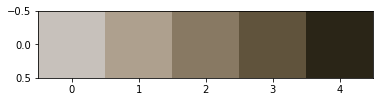

In [5]:
# arrange the cluster_centers of KMeans output according to frequency of each label
def arrange_cluster_centers(clt):
    lb_counts = Counter(clt.labels_)
    
    tmp_dict = {}
    for idx, pixel in enumerate(clt.cluster_centers_):
        tmp_dict[ lb_counts[idx] ] = pixel  # { frequency of label : color of label } mapping
    
    centers_aranged_dict = dict(sorted(tmp_dict.items(), reverse=True))  # arrange the dict according to key (frequency of label)

    centers_aranged_arr = np.array(list(centers_aranged_dict.values()))  # pack colors into one array
    centers_aranged_arr = centers_aranged_arr.round().astype("uint8")  # tranform the type to integer
    centers_aranged_arr = np.expand_dims(centers_aranged_arr, 0)  # add one dimension for visualization
    return centers_aranged_arr


expected_num_col = 5 #cluster number

# Extract dominant color using KMeans
clt = KMeans(n_clusters = expected_num_col)
clt.fit(concat_arr)


# Visualization
centers_aranged_arr = arrange_cluster_centers(clt)
plt.imshow(centers_aranged_arr)
plt.show()

#### 3-3. Compare to the original image (visualization)

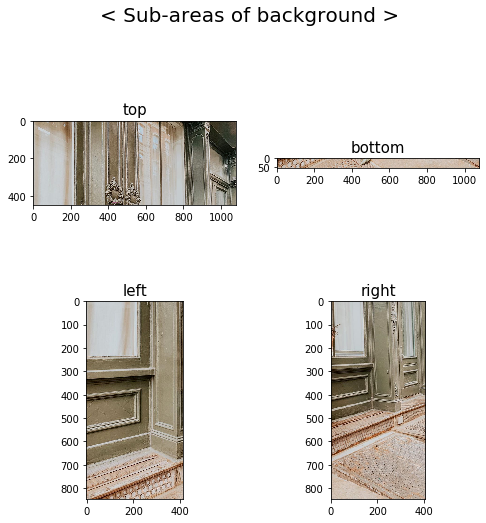

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
fig.suptitle('< Sub-areas of background >', size=20)
axes[0, 0].imshow( top )
axes[0, 0].set_title("top", size=15)
axes[0, 1].imshow( bottom )
axes[0, 1].set_title("bottom", size=15)
axes[1, 0].imshow( left )
axes[1, 0].set_title("left", size=15)
axes[1, 1].imshow( right )
axes[1, 1].set_title("right", size=15)
plt.show()

## 4. Save the result colors into json

In [7]:
filename = file_path.split('/')[-1]

r_dict = {filename : centers_aranged_arr.tolist()[0]}
r_json = json.dumps(r_dict)
r_json

'{"thecatwilliams_004_502Likes.png": [[199, 193, 187], [174, 160, 142], [136, 121, 99], [96, 83, 60], [42, 37, 23]]}'